In [1]:
import os
from pathlib import Path
from typing import Tuple
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## General view

In [2]:
def anonymise_df_repr(df_repr: str, placeholder: str = '[hidden]') -> str:
    s_list = df_repr.split('\n')
    
    for i, s in enumerate(s_list):
        if not s.startswith('participant_id') and not s.startswith(' ' * 14):
            s_list[i] = placeholder + s[len(placeholder):]
            
    return '\n'.join(s_list)

In [3]:
PROJECT_DIR = Path(os.environ['PROJECT_DIR'])
PREPROCESSED_DATA_PATH = PROJECT_DIR / 'data/preprocessed_data'

In [4]:
df = pd.read_csv(PREPROCESSED_DATA_PATH / 'data.csv')
df = df.drop(['start_time', 'end_time', 'text', 'source', 'confidence', 'split'], axis=1)
df = df.set_index('participant_id')

print(anonymise_df_repr(df.sample(3, random_state=42).to_string()))

                words_cnt  duration  gender  phq_binary  phq_score  pcl-c (ptsd)  ptsd severity
participant_id                                                                                 
[hidden]               99      27.7    male         1.0       19.0           1.0           60.0
[hidden]               52      15.6    male         0.0        5.0           0.0           24.0
[hidden]               41      11.4  female         1.0       15.0           1.0           62.0


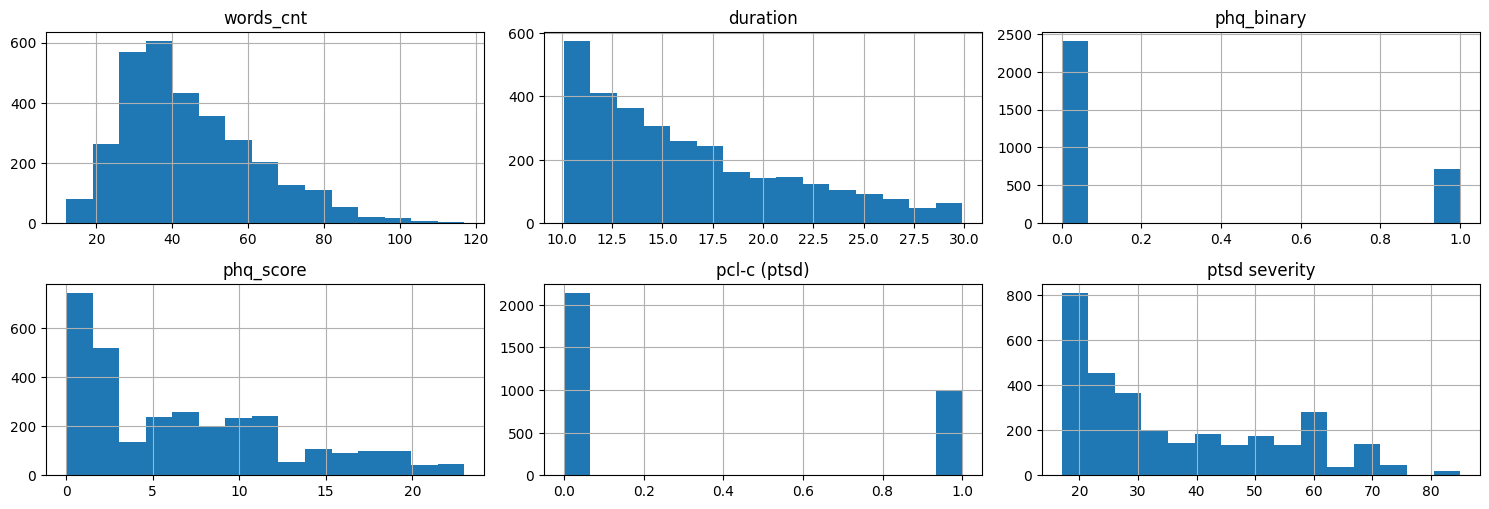

In [5]:
# dataset features distribution
num_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[num_columns].hist(bins=15, figsize=(15, 10), layout=(4,3))
plt.tight_layout()

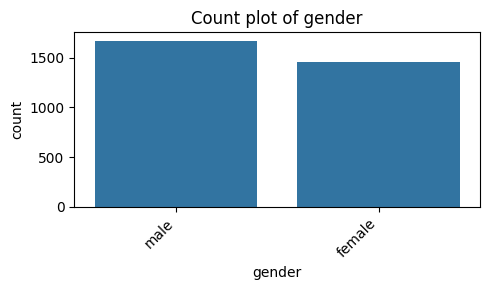

In [6]:
# gender
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='gender')
plt.title(f'Count plot of gender')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'PHQ binary among recordings')

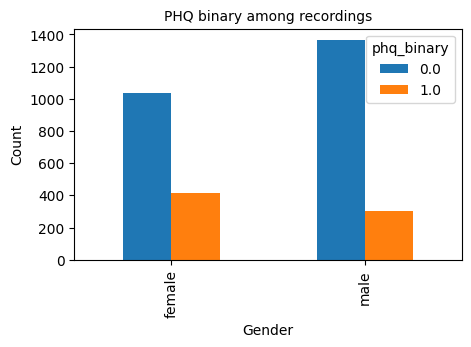

In [7]:
# participants recordings representations by sex within phq_binary
gender_distress_count = df.groupby('gender')['phq_binary'].value_counts().unstack()
gender_distress_count.plot(kind='bar', figsize=(5, 3))
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('PHQ binary among recordings', fontsize=10)

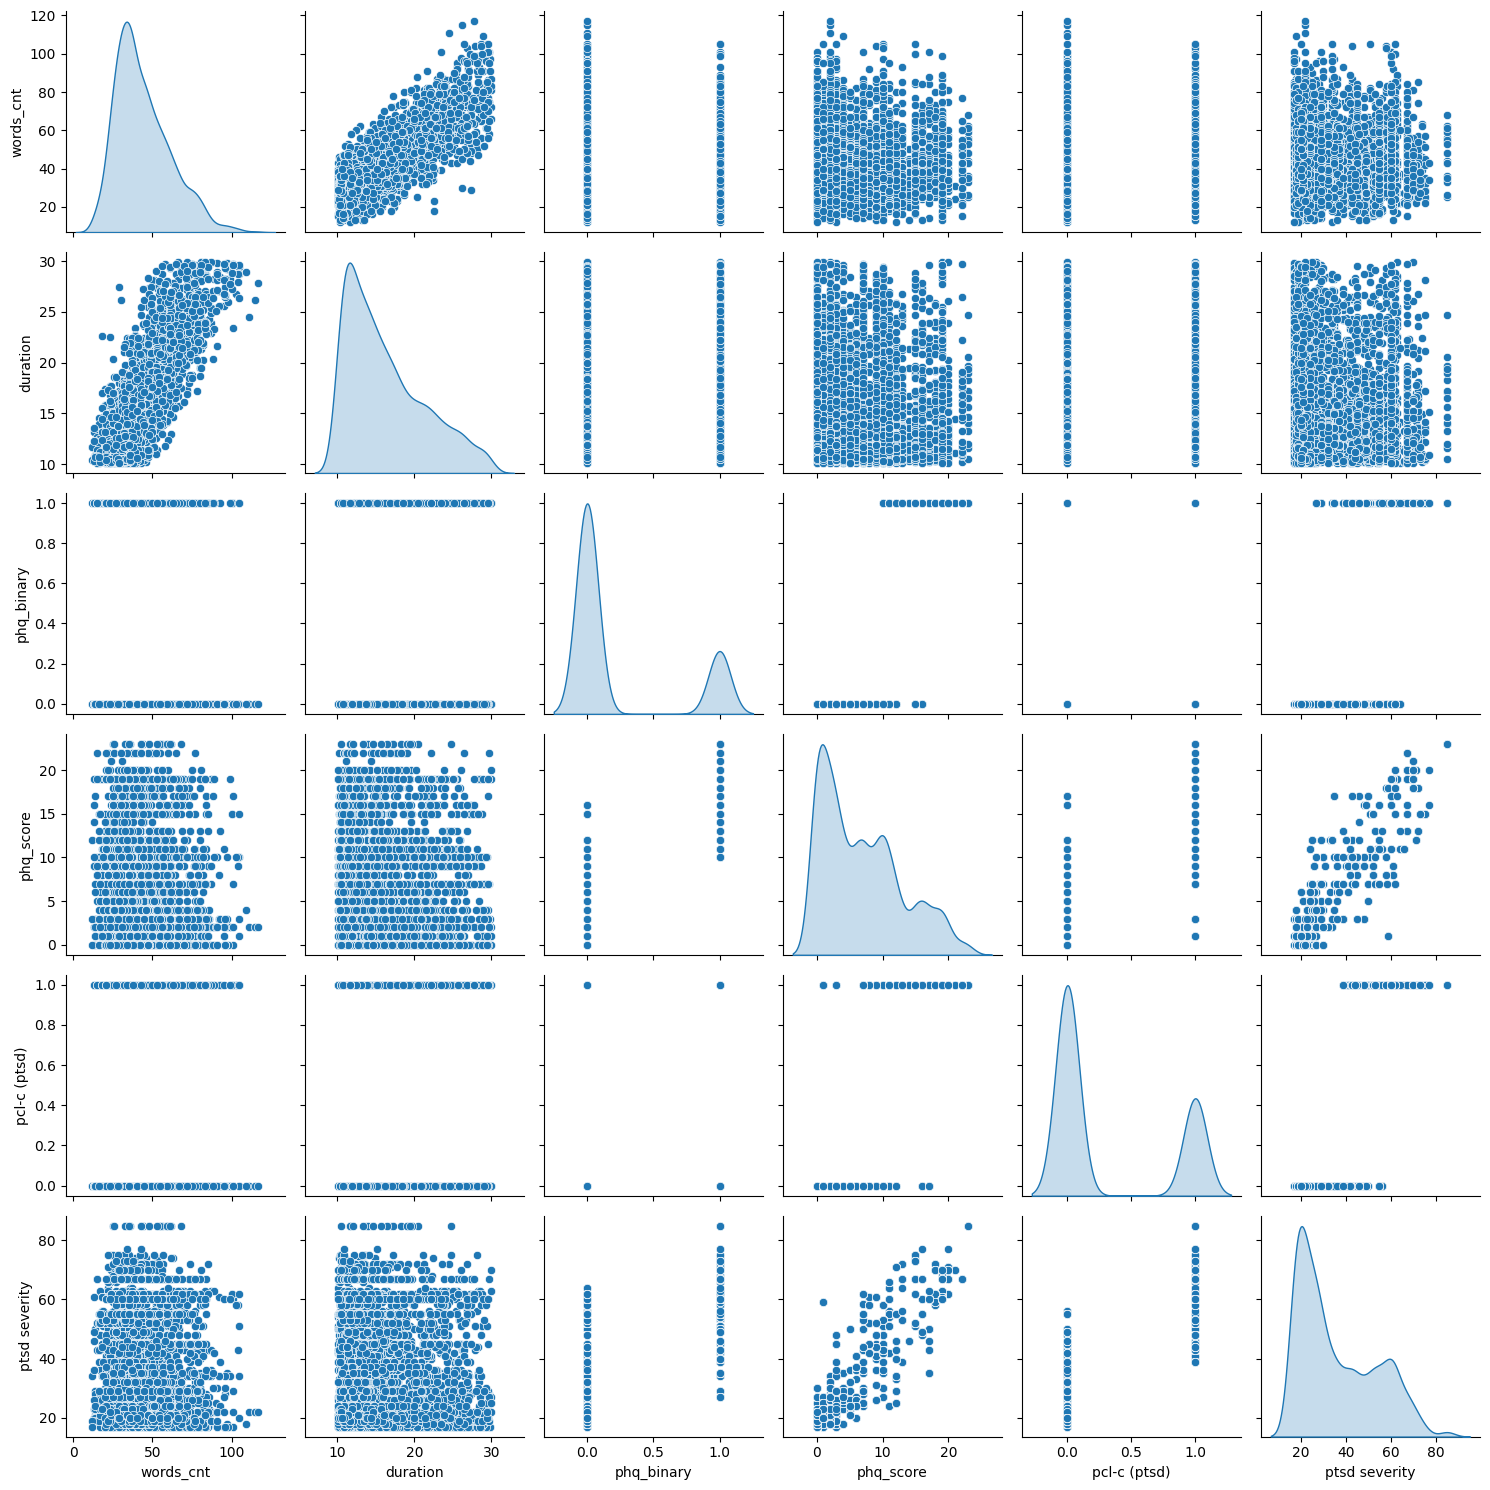

In [8]:
# feature-vs-feature pairplot
sns.pairplot(df[num_columns], diag_kind='kde')
plt.tight_layout()

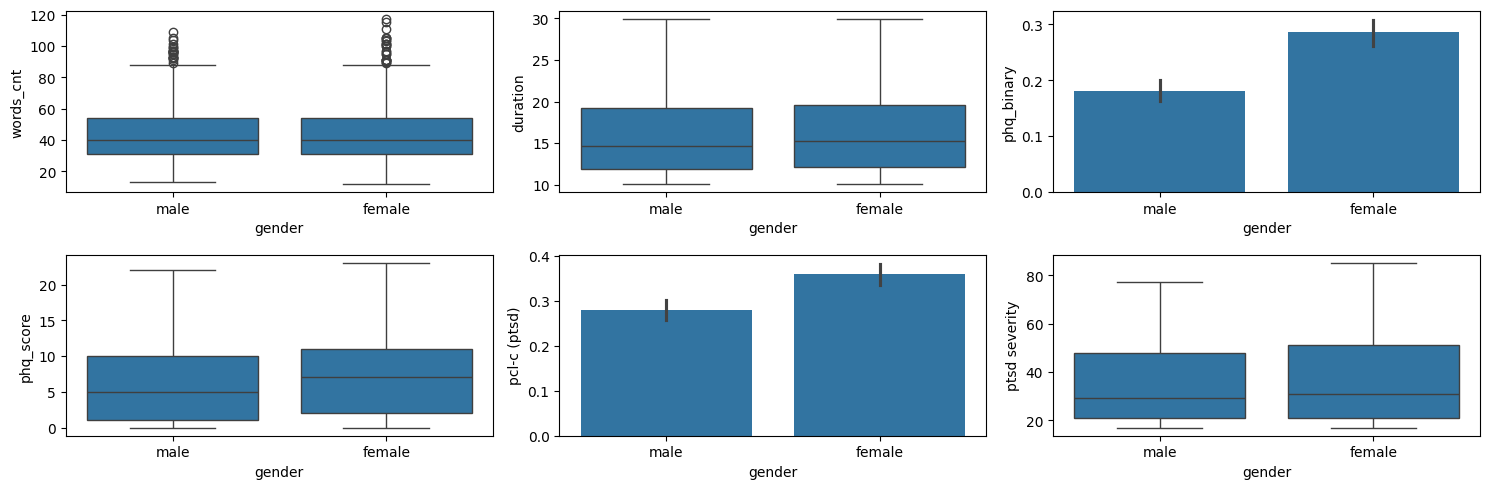

In [9]:
# entries grouped by participant's sex
fig, ax = plt.subplots(2, 3, figsize = (15, 5))
ax = ax.flatten()
for i, column in enumerate(num_columns):
    if len(df[column].unique()) == 2:
        sns.barplot(data=df, x='gender', y=column, ax=ax[i])
    else:
        sns.boxplot(data=df, x='gender', y=column, ax=ax[i])

plt.tight_layout()

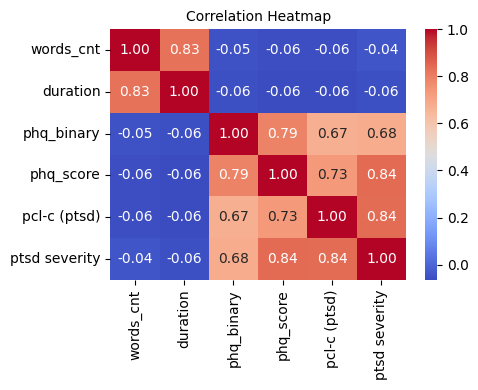

In [10]:
# correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(df[num_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=10)
plt.tight_layout()

## Train-test split

In [11]:
TEST_PERCENTAGE = 0.2
RANDOM_STATE = 0

In [12]:
participants_df = pd.read_csv(PREPROCESSED_DATA_PATH / 'data.csv').drop_duplicates(subset='participant_id')

Text(0.5, 1.0, 'PHQ binary among unique participants')

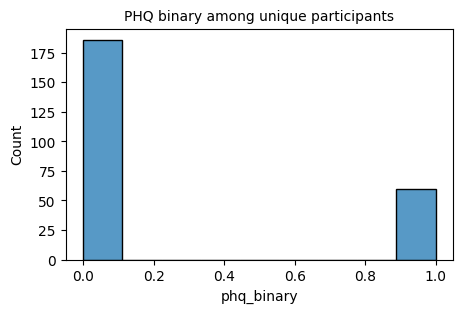

In [13]:
phq_binary_counts = participants_df['phq_binary'].value_counts()

plt.figure(figsize=(5, 3))
sns.histplot(participants_df['phq_binary'])
plt.title('PHQ binary among unique participants', fontsize=10)

In [14]:
# split with stratification
test_positive_diagnosys_ids = participants_df['participant_id'][participants_df['phq_binary'] == 1].sample(int(phq_binary_counts[1] * TEST_PERCENTAGE), random_state=RANDOM_STATE)
test_negative_diagnosys_ids = participants_df['participant_id'][participants_df['phq_binary'] == 0].sample(int(phq_binary_counts[0] * TEST_PERCENTAGE), random_state=RANDOM_STATE)
test_ids = pd.concat([test_positive_diagnosys_ids, test_negative_diagnosys_ids]).to_list()

In [15]:
# unique participants percentage
participants_df['split'] = participants_df['participant_id'].apply(
    lambda i: 'test' if int(i) in test_ids else 'train'
)
participants_df['split'].value_counts() / len(participants_df)

split
train    0.800813
test     0.199187
Name: count, dtype: float64

In [16]:
df['split'] = None
df['split'][df.index.isin(test_ids)] = 'test'
df['split'][~df.index.isin(test_ids)] = 'train'

/tmp/ipykernel_7095/3181050435.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['split'][df.index.isin(test_ids)] = 'test'
/tmp/ipykernel_7095/3181050435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

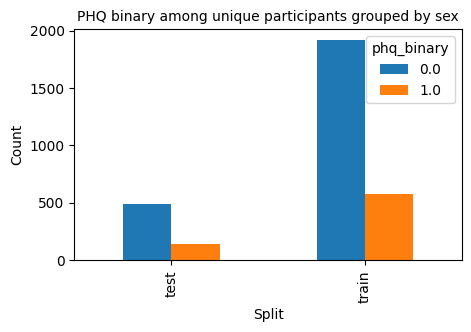

In [17]:
# participants recordings representation by split
gender_distress_count = df.groupby('split')['phq_binary'].value_counts().unstack()
gender_distress_count.plot(kind='bar', figsize=(5, 3))
plt.title('PHQ binary among unique participants grouped by sex', fontsize=10)
plt.xlabel('Split')
plt.ylabel('Count')
plt.show()

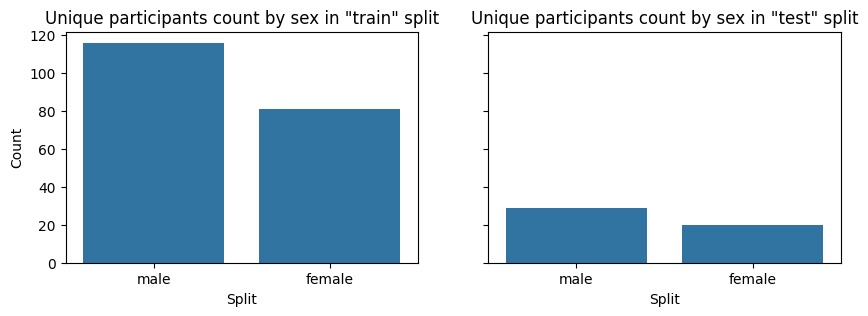

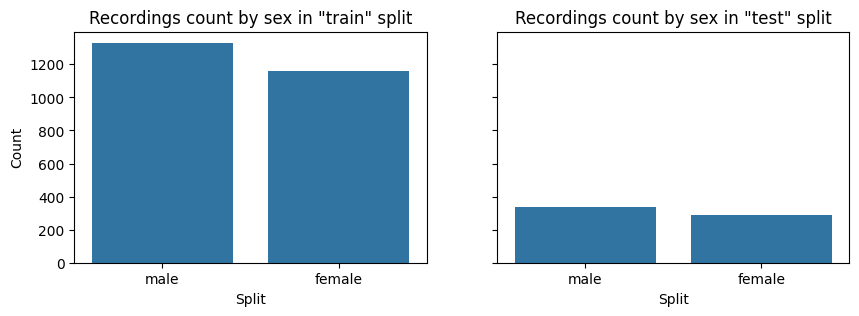

In [18]:
# participants recordings representation by split
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax = ax.flatten()
for i, split in enumerate(['train', 'test']):
    sns.countplot(data=participants_df[participants_df['split'] == split], x='gender', ax=ax[i])
    ax[i].set_title(f'Unique participants count by sex in "{split}" split')
    ax[i].set_xlabel('Split')
    ax[i].set_ylabel('Count')

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax = ax.flatten()
for i, split in enumerate(['train', 'test']):
    sns.countplot(data=df[df['split'] == split], x='gender', ax=ax[i])
    ax[i].set_title(f'Recordings count by sex in "{split}" split')
    ax[i].set_xlabel('Split')
    ax[i].set_ylabel('Count')

In [19]:
# participants recordings percentage
original_positives_percentage = 100 * df['phq_binary'].sum() / len(df)
train_positives_percentage = 100 * df['phq_binary'][df['split'] == 'train'].sum() / len(df[df['split'] == 'train'])
test_positives_percentage = 100 * df['phq_binary'][df['split'] == 'test'].sum() / len(df[df['split'] == 'test'])

print(f'{original_positives_percentage = :.2f}\n{train_positives_percentage = :.2f}\n{test_positives_percentage = :.2f}')

original_positives_percentage = 22.99
train_positives_percentage = 23.10
test_positives_percentage = 22.54
